Kiki Chandra & Zoher Ghadyali

Data Science Spring 2016

CYOA Project

# MODEL ITERATION 2

In this notebook, we build off of the work done in our data exploration and our first iteration of the model. In our first iteration, we spent a lot of time separating our data into subsets of single words, phrases, and sentences. In this iteration, we dedicate less time to this idea and instead focus on how we can make the single words that compose a sentiment or phrase a more valuable indicator of the sentiment. 

We start off by doing something very different from our previous iteration, which is training a model on all of the data, regardless of whether it is a sentence, phrase, or single word, and see how that model does. We then try to achieve similar results by combining ideas from this new approach with our previous iteration.

## Starting off by using the example from class

The cell below is practically the same as the one we went through in class that uses the tfidf vectorizer to create a matrix where the columns are the individual words used in each post and the rows are each post. We train the model using this matrix, calculate the accuracy of the model in our train-test split, and then use the model to make our predictions on the test data.

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.tag.perceptron import PerceptronTagger
import nltk
import cPickle

%matplotlib inline

In [2]:
train_df = pd.read_table('train.tsv')
test_df = pd.read_table('test.tsv')

vectorizer = TfidfVectorizer()
vectorizer.fit(train_df.Phrase)

X = vectorizer.transform(train_df.Phrase)
y = train_df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)
print "Accuracy", model.score(X_test, y_test)

model.fit(X, y) #retrain the model using all of the data now before we predict on the test dataset
result = model.predict(vectorizer.transform(test_df.Phrase))
output = pd.DataFrame(data={"PhraseId":test_df["PhraseId"], "Sentiment":result})
output.to_csv( "ZG_rotten_tomatoes_model2.csv", index=False, quoting=3 )

Accuracy 0.622991157247


/home/kiki/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This csv file got a Kaggle score of 0.6026. We were unable to improve upon this score but we prioritized trying different methods we found from online tutorials and research.

## Using the single words in the train dataset as a lookup table

So pulling from previous iterations of our model, we are going to create a dataframe that contains only the single words from the data. The plot is a histogram that counts how many records in the train data have a certain sentiment and the percentages below that are printed out show what percentage of the train data has that sentiment. We see a lot of 2s (neutral) which makes sense given that these are only the single words and most do not have a lot of connotations by themselves.

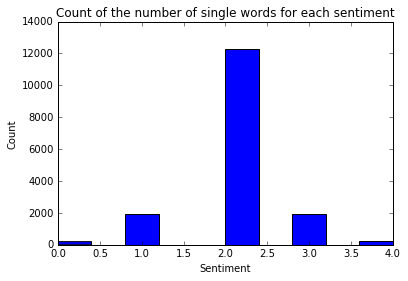

Sentiment:  0 Percentage:  0.0119170044159
Sentiment:  1 Percentage:  0.115842961708
Sentiment:  2 Percentage:  0.742786280322
Sentiment:  3 Percentage:  0.116145423749
Sentiment:  4 Percentage:  0.0133083298046


In [16]:
train_df = pd.read_table('train.tsv')
train_df["containsSpaces"] = train_df["Phrase"].apply(lambda x: ' ' in x)
sw = train_df[train_df.containsSpaces == False]

plt.hist(sw.Sentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of the number of single words for each sentiment')
plt.show()
for i in range(0, 5):
    print "Sentiment: ", i, "Percentage: ", len(sw[sw.Sentiment == i]) / float(len(sw))

For this iteration of the model, we decided to use the single words as a lookup table. So instead of training a model and predicting the test data off of that, we use a dictionary of all the single words and their sentiment from the train data and we use it to average the sentiment of each phrase. We then calculate our accuracy within the train data by comparing the calculated sentiment to the actual sentiment.

In [6]:
sw_dict = sw.set_index('Phrase')['Sentiment'].to_dict()

def get_sentiment_single_word(word):
    """ Takes a word in as input, looks for it in the dictionary of single words and their sentiments, and returns the
    sentiment of the word if it is in the dictionary. Otherwise it returns 2 which is neutral"""
    if word in sw_dict:
        return sw_dict[word]
    else:
        return 2

def get_sentiment_phrase(phrase):
    """Takes a phrase as input, creates an empty list of the sentiments for each word in that phrase, and loops
    through the words in the phrase, appending the sentiment of each word to the list. Once we have finished, we
    return the average of the values in the list, or if the list is empty, we return 2"""
    phrase_sentiment = []
    for word in phrase.split():
        phrase_sentiment.append(get_sentiment_single_word(word))
    if len(phrase_sentiment):
        return int(sum(phrase_sentiment)/len(phrase_sentiment))
    else:
        return 2

train_df["calcSentiment"] = train_df["Phrase"].apply(get_sentiment_phrase)
row_ids = train_df[train_df.Sentiment != train_df.calcSentiment].index
print "Number wrong", len(row_ids)
print "Percentage wrong", (float(len(row_ids))/len(train_df)) * 100

Number wrong 70410
Percentage wrong 45.1172625913


So we now take the functions we just tested on the train dataset and apply them to the test data. We are using a very simple function that we will then try and improve upon later in this iteration. In the section below, after calculating the sentiment of the test data, we plot a histogram that shows how many phrases of each sentiment we calculated from the train data and the percentage of the total dataset that each sentiment has. We find very few 0s and 4s which is due to our averaging of the list of sentiments for each word in the phrase.

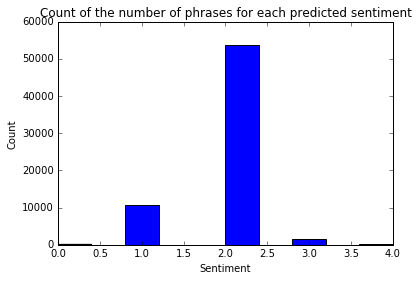

Sentiment:  0 Percentage:  0.0017649188439
Sentiment:  1 Percentage:  0.161301514512
Sentiment:  2 Percentage:  0.811002835938
Sentiment:  3 Percentage:  0.0238641163338
Sentiment:  4 Percentage:  0.00206661437277


In [7]:
test_df = pd.read_table('test.tsv')

test_df["Sentiment"] = test_df["Phrase"].apply(get_sentiment_phrase)
output = test_df[['PhraseId', 'Sentiment']]

plt.hist(output.Sentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of the number of phrases for each predicted sentiment')
plt.show()
for i in range(0, 5):
    print "Sentiment: ", i, "Percentage: ", len(output[output.Sentiment == i]) / float(len(output))

output.to_csv( "ZG_rotten_tomatoes_model3.csv", index=False, quoting=3 )

The resulting csv file got a Kaggle score of 0.56008 which surprised us given the simplicity of this approach. We will next try to improve our get_sentiment_phrase function to try and get more extreme values instead of averaging only to 2. We again show the histogram and we see that our second iteration of get_sentiment_phrase is working because we see much higher counts of phrases that have sentiments 0, 1, 3, and 4.

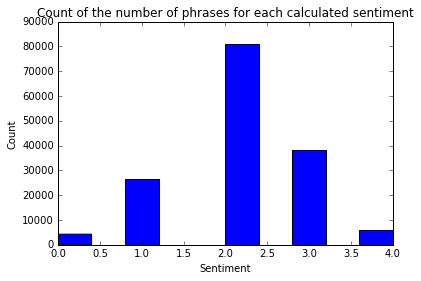

Sentiment:  0 Percentage:  0.0274445726003
Sentiment:  1 Percentage:  0.169883378188
Sentiment:  2 Percentage:  0.519716775599
Sentiment:  3 Percentage:  0.244950660003
Sentiment:  4 Percentage:  0.0380046136101
Number wrong 69969
Percentage wrong 44.8346789696


In [9]:
train_df = pd.read_table('train.tsv')

def get_sentiment_phrase(phrase):
    """This function is very similar to the previous iteration except that we only append sentiments to the list for
    each phrase if they are not 2. This should force our averaging closer to the extremes."""
    phrase_sentiment = []
    for word in phrase.split():
        word_sentiment = get_sentiment_single_word(word)
        if word_sentiment > 2 or word_sentiment < 2:
            phrase_sentiment.append(word_sentiment)
    if len(phrase_sentiment):
        return int(sum(phrase_sentiment)/len(phrase_sentiment))
    else:
        return 2

train_df["calcSentiment"] = train_df["Phrase"].apply(get_sentiment_phrase)

plt.hist(train_df.calcSentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of the number of phrases for each calculated sentiment')
plt.show()
for i in range(0, 5):
    print "Sentiment: ", i, "Percentage: ", len(train_df[train_df.calcSentiment == i]) / float(len(train_df))
    
row_ids = train_df[train_df.Sentiment != train_df.calcSentiment].index
print "Number wrong", len(row_ids)
print "Percentage wrong", (float(len(row_ids))/len(train_df)) * 100

So if we look at the percentage that this function calculated incorrectly among the training data as compared to the previous function, we see a 0.28% improvement in accuracy. We now apply the function again to the test dataset submit to Kaggle.

In [109]:
test_df = pd.read_table('test.tsv')

test_df["Sentiment"] = test_df["Phrase"].apply(get_sentiment_phrase2)
output = test_df[['PhraseId', 'Sentiment']]

output.to_csv( "ZG_rotten_tomatoes_model4.csv", index=False, quoting=3 )

The resulting csv got a Kaggle score of 0.55836 which is actually a decrease by 0.00172 from our previous function's score. There is a lot more that we could do here. We could look at the position of each sentiment within the phrase and find the most important parts of the phrase. We could take the sentiment from the middle of the phrase as the most important sentiment. We could set the sentiment of the phrase to be the value that appears most often in the list of sentiments for each phrase. Given more time, we would like to explore this further but instead, we decided to try and tackle a better method for creating the dictionary of single words.

## Using the vocab words from the tfidf vectorizer for the lookup table

The code below is identical to the one we run above except that this time, we clean the phrases before training the vecotrizer. We also store the vocab as a list which we will use to create a dictionary for each vocab word and its predicted sentiment value using the model.

In [17]:
train_df = pd.read_table('train.tsv')

def review_to_words( word ):
    """Takes as input a phrase or a word, cleans all punctuation such as commas or hyphens from it and makes all
    letters lowercase, then returns the phrase"""
    letters_only = re.sub("[^a-zA-Z]", " ", word) 
    word = letters_only.lower()
    return word

train_df.Phrase = train_df.Phrase.apply(review_to_words)

vectorizer = TfidfVectorizer()
vectorizer.fit(train_df.Phrase)
vocab = vectorizer.get_feature_names()

X = vectorizer.transform(train_df.Phrase)
y = train_df.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)
print "Accuracy", model.score(X_test, y_test)

Accuracy 0.623183391003


We now create a dictionary of the vocab words where the value for each word is the sentiment predicted using the vectorizer. We then redefine our get_sentiment_phrase function and the helper function get_sentiment_single_word to use the new dictionary and calculate our accuracy within the training dataset. In looking at the resulting histogram that is our calculated sentiment, we are again calculating a lot of sentiments as 2 which is neutral and is probably because we are again averaging each phrase and because a lot of the vocab words probably have a value of 2.

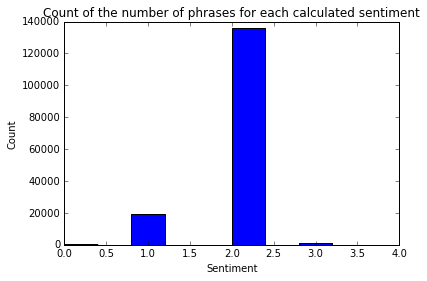

Sentiment:  0 Percentage:  0.000192233756248
Sentiment:  1 Percentage:  0.122529796232
Sentiment:  2 Percentage:  0.869498910675
Sentiment:  3 Percentage:  0.00748430090991
Sentiment:  4 Percentage:  0.000294758426246
Number wrong 70344
Percentage wrong 45.0749711649


In [18]:
model.fit(X, y) #retrain the model using all of the data now before we predict on the test dataset
vocab_dict = dict(zip(vocab, model.predict(vectorizer.transform(vocab))))

train_df = pd.read_table('train.tsv')

def get_sentiment_single_word(word):
    if word in vocab_dict:
        return vocab_dict[word]
    else:
        return 2

def get_sentiment_phrase(phrase):
    phrase_sentiment = []
    for word in phrase.split():
        phrase_sentiment.append(get_sentiment_single_word(word))
    if len(phrase_sentiment):
        return int(sum(phrase_sentiment)/len(phrase_sentiment))
    else:
        return 2

train_df["calcSentiment"] = train_df["Phrase"].apply(get_sentiment_phrase)

plt.hist(train_df.calcSentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of the number of phrases for each calculated sentiment')
plt.show()
for i in range(0, 5):
    print "Sentiment: ", i, "Percentage: ", len(train_df[train_df.calcSentiment == i]) / float(len(train_df))
    
row_ids = train_df[train_df.Sentiment != train_df.calcSentiment].index
print "Number wrong", len(row_ids)
print "Percentage wrong", (float(len(row_ids))/len(train_df)) * 100

We have a slight improvement in accuracy over our original function but have lost accuracy compared to our second function. We now apply this method to the test data set to see our Kaggle score.

In [19]:
test_df = pd.read_table('test.tsv')
test_df["Sentiment"] = test_df["Phrase"].apply(get_sentiment_phrase)
output = test_df[['PhraseId', 'Sentiment']]
output.to_csv("ZG_rotten_tomatoes_model5.csv", index=False, quoting=3 )

This produced a Kaggle score of 0.54805 which is still worse than using the single words from the train dataset as a lookup table. One reason for this is that all of the words that appear in the train dataset also appear in the test dataset and so for each individual word in the test data set, we have an accurate sentiment. The computations we chose to perform manually we could also use a model to predict, as we did at the beginning of this notebook, but we wanted to see how our own interpretation of sentiment was performing.

## Experimenting with parts of speech and negation words

One of the other final models we developed was geared towards using parts of speech and negation words to see how accurately we could use them to predict sentiment. We mainly focused on running analysis on phrases, rather than on everything, because of runtime. We did a lot of research through papers (such as http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5212278) and online videos to learn about different methods that are currently being used for sentiment analysis, and what some interesting techniques people have used are. The bag of words model, which we used previously, came up a lot, as did using the TF-IDF model and creating decision trees. Another interesting area of research is figuring out how to use parts of speech and negation words effectively. For example, a sentence such as "I loved the movie even though the plot was not steller" has an overall positive sentiment, but the relationship between the negation words ('even','though','not') and the adjectives ('loved','stellar') is complicated to analyse. We tried to focus on this area in our next model, to see how we could use these relationships to correctly predict sentiment.

In [14]:
#reading table, creating sentences data frame
train = pd.read_table('train.tsv')
train_sentences = train.groupby('SentenceId').first().reset_index()

#creating new column length (number of words) and ordering data frame by length and sentence id
train["Length"] = train['Phrase'].apply(lambda x: len(x.split()))
ordered = train.sort(['SentenceId', 'Length'], ascending=[1, 0])

#binning rows into categories 
max_length = max(ordered['Length'])
bins = [0, 1, max_length/15, max_length/4, max_length/2, max_length]
group_names = ['SingleWord', 'SmallPhrase', 'Phrase', 'LongPhrase', 'Sentences']
categories = pd.cut(ordered['Length'], bins, labels=group_names)
ordered['categories'] = pd.cut(ordered['Length'], bins, labels=group_names)

tagger = PerceptronTagger()  #loading part of speech tagger to save time

print bins[::-1]

[52, 26, 13, 3, 1, 0]


/home/kiki/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


We split the data into different categories by bins and created a data frame of single words. Then, we went through the steps of cleaning and parsing the words, assigning parts of speech to each word and creating a column 'POS' to store that value. We then trained a random forest classifier on this data frame. All of this code can be found in the ipython notebook 'kc_model_iteration_2', but for clarity we simply saved the resulting data frame as a .csv file and loaded it. 

In [6]:
singleword = pd.read_csv('singleword.csv')
singleword

,Unnamed: 0,index,PhraseId,SentenceId,Phrase,Sentiment,Length,categories,POS
0,0,3,4,1,A,2,1,SingleWord,['DT']
1,1,4,5,1,series,2,1,SingleWord,['NN']
2,2,6,7,1,of,2,1,SingleWord,['IN']
3,3,8,9,1,escapades,2,1,SingleWord,['NNS']
4,4,11,12,1,demonstrating,2,1,SingleWord,['VBG']
5,5,13,14,1,the,2,1,SingleWord,['DT']
6,6,14,15,1,adage,2,1,SingleWord,['NN']
7,7,16,17,1,that,2,1,SingleWord,['IN']
8,8,18,19,1,what,2,1,SingleWord,['WP']
9,9,20,21,1,is,2,1,SingleWord,['VBZ']


With the singleword table from the train data, we then loaded the test data and created the same length column and ordered the dataset.<br>
We ran the forest model only on the test single words in order to get their sentiment, and use that for developing phrases and sentences; this dataframe, singleword_test, is also loaded here as a .csv. 
The next data frame we created was test_phrases, which contains all the rows that do not have full sentences or single words. This is also loaded as a .csv.

In [15]:
test = pd.read_table('test.tsv')
test["Length"] = test['Phrase'].apply(lambda x: len(x.split()))
ordered = test.sort(['SentenceId', 'Length'], ascending=[1, 0])

/home/kiki/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [16]:
singleword_test = pd.read_csv('singleword_test.csv')
test_phrases = pd.read_csv('test_phrases.csv')

In [ ]:
import re, string

test_phrases['SentPOS'].tolist()
pattern = re.compile('[\W_]+')
length = test_phrases['SentPOS'].size

predicted_sent = []

for i in xrange(48000,length):
    print 'index: ',i
    raw_order = pattern.sub(' ', test_phrases['SentPOS'][i])
    order = raw_order.replace('\[\[\]\]', '').split()
    str_to_int = [int(i) if i.isdigit() else i for i in order]
    test = [tuple(str_to_int[i:i+2]) for i in range(0, len(str_to_int),2)]
    overall_sent = 0
    reverse = {0:4,1:3,2:2,3:1,4:0}
    rev = False
    count = 0
    pos_words = 0
    neg_words = 0
    affected = ['RB','RBR','RBS','JJS','JJR','JJ']
    for pair in test:
        try:
            init_val = pair[0]
            if init_val == 2:
                continue
            else:
                count += 1
                #print len(pair),init_val,'--------------'
                if pair[1] == 'NEGATE':
                    print 'reversing'
                    val = reverse[pair[0]]
                    rev = not rev
                else:
                    if rev:
                        if pair[1] in affected:
                            print 'affected'
                            val = reverse[init_val]
                    else:
                        val = init_val
                    if val == 3 or val == 4:
                        pos_words += 1
                    else: 
                        neg_words += 1
                overall_sent += val
        except: 
            continue
    print count, pos_words, neg_words
    if ((len(test) > 2 and count > 2) or (len(test) < 3 and count > 0)) and pos_words != neg_words:
        if neg_words == 0:
            sentiment = 4
        elif pos_words == 0:
            sentiment == 0
        else:
            sentiment = int(round(overall_sent/float(count)))
    else:
        sentiment = 2
    test_phrases['Sentiment'][i] = sentiment
    print 'sentiment: ',test_phrases['Sentiment'][i], ' id: ',test_phrases['PhraseId'][i]
    #print sentiment
    predicted_sent.append(sentiment)
test_phrases

The code above is where a majority of time was spent, both in running and developing. Essentially, we go through each word in a phrase of test_phrases, and check the part of speech. If the word is tagged as a 'NEGATE' word (it appears in a list of words which commonly flip the meaning of the sentence, such as 'but' and 'however'), the sentiment of the adjectives and adverbs is reversed until the phrase ends or another negation word is met. We got the idea from the paper that is linked above, which gives models such as this as an example of how part of speech can be used. It was a pretty basic interpretation of the relationship between negation words and part of speech, but it actually worked surprisingly well. <br>
We took a sum of the sentiments of each word in the phrase (using the above description, and disregarding neutral words). If the sum was smaller than a certain cut-off, relative to the phrase length, or the amount of positive sentiments and negative sentiments was equal, then we assign an overall sentiment value of two. If those conditions are not met, we then do further checks to see if the sentence is overall more positive of more negative, and assign a sentiment accordingly. 

In [17]:
#function to clean phrases in test_sentences
def basic_clean( raw_review ):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    words = letters_only.lower().split()
    return words

For sentences, we tried a few different models to see which gave the best accuracy. 
* Averaging the sentiments of each phrase in a sentence for the phrases that exist, otherwise going through and using the same code as above on the remaining sentences, using the test single words as a lookup table: accuracy - 0.521
* Doing the same as the previous bullet point, but using the train single words as a lookup table: accuracy - 0.517
* Not using phrase sentiment averages, but using the test single words as a lookup table for every sentence: accuracy - 0.551
* Doing the same as the previous bullet point, but using the train single words as a lookup table: accuracy - 0.532

Interestingly, the third bullet point performed significantly better. We could not think of too many valid reasons that the test single words would produce more accurate results, except that it indicates that the way the sentence is being parsed with word sentiment needs more improvement. Also, the improved performance when not using the phrase sentiments also points to our model for phrases being too simplistic. 

In [ ]:
test_sentences['Sentiment'] = 2
sentences_amt = test_sentences['Sentiment'].size
negations = ['than','however','but','although','not','no','neither','never','noone','nobody','none','nor','nothing','nowhere','hardly','scarcely','isn','wasn','didn']
reverse = {0:4,1:3,2:2,3:1,4:0}

for i in xrange(0,sentences_amt):
    sent_id = test_sentences['SentenceId'][i]
    sent = test_sentences['Sentiment'][i]
    sentiment = 0
    phrase = basic_clean(test_sentences['Phrase'][i])
    rev = False
    neg_count = 0
    pos_count = 0
    count = 0
    for word in phrase:
        try:
            sw = singleword[singleword.Phrase == word]
            word_sent = int(sw.Sentiment)
            if word in negations:
                rev = not rev
                word_sent = reverse[word_sent]
            if word_sent == 0 or word_sent == 1:
                neg_count +=1
                count +=1
            elif word_sent == 3 or word_sent == 4:
                pos_count +=1
                count+=1
            else:
                continue
            sentiment += int(word_sent)
        except:
            continue
    if count > 2 and neg_count != pos_count:
        if pos_count > neg_count:
            if neg_count == 0:
                sent = 4
            else:
                sent = 3
        elif neg_count > pos_count:
            if pos_count == 0:
                sent = 0
            else:
                sent = 1
        else:
            sent = int(round(sentiment/len(count)))
    test_phrases['Sentiment'][i] = sent
    print 'index: ',test_sentences['PhraseId'][i],sent

In [ ]:
len(test_sentences[test_sentences.Sentiment != 2])
print len(test_sentences),len(singleword_test),len(test_phrases),len(test)


3310 10014 52968 66292

In [ ]:
df = pd.merge(test_sentences, test_phrases, how='outer')
remaining = test[~test['PhraseId'].isin(df['PhraseId'])].reset_index()
remaining['Sentiment'] = 2
df1 = pd.merge(df, remaining, how='outer')
df2 = df1.sort(['PhraseId']).reset_index(drop=True)
df2

In [ ]:
df2["PhraseId"] = df2["PhraseId"].apply(lambda x : int(x))
df2["Sentiment"] = df2["Sentiment"].apply(lambda x : int(x))
print len(df2)

66292

In [ ]:
output = pd.DataFrame(data={"PhraseId":df2["PhraseId"], "Sentiment":df2['Sentiment']})

# Use pandas to write the comma-separated output file
output.to_csv( "rotten_tomatoes_model1.csv", index=False, quoting=3 )

With this model, the highest accuracy we could achieve was 0.551.

##Future Steps <br>

Regarding predicting single word sentiment in a better way, it would be interesting to use NLTK's similar() function, which groups words based on similarity (ie synonyms, collocations), and using that on the train data and test data in order to find information about the sentiments of words that are similar, and create a model based off of that. Additionally, pointwise-mutual information could be used to find collocations and word information without using the nltk function. <br>
Another area of sentiment analysis that we could explore is classification, which uses cross entropy and total surprisal in order to classify texts. We could train models that are super positive, positive, neutral, negative, and super negative, and run each test phrases through them to compute the most likely classification (the one with the lowest cross entropy). <br>
Finally, doing more extensive research into how negation words impact parts of speech would also be very valuable.